<a href="https://colab.research.google.com/github/AntarikshVerma/AI_Agent_In_Langgraph/blob/main/travel_planner_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building a Travel Planner with LangGraph:
##Overview
This tutorial guides you through the process of creating a simple Travel Planner using LangGraph, a library for building stateful, multi-step applications with language models. The Travel Planner demonstrates how to structure a conversational AI application that collects user input and generates personalized travel itineraries.

##Key Components
1.  StateGraph: The core of our application, defining the flow of our Travel Planner.
2.  PlannerState: A custom type representing the state of our planning process.
3.  Node Functions: Individual steps in our planning process (input_city, input_interests, create_itinerary).
4.  LLM Integration: Utilizing a language model to generate the final itinerary.
Method Details

Our Travel Planner follows a straightforward, three-step process:

####City Input:
The application prompts the user to enter the city they want to visit.
This information is stored in the state.

####Interests Input:
The user is asked to provide their interests for the trip.
These interests are stored as a list in the state.

####Itinerary Creation:
Using the collected city and interests, the application leverages a language model to generate a personalized day trip itinerary.
The generated itinerary is presented to the user.
The flow between these steps is managed by LangGraph, which handles the state transitions and ensures that each step is executed in the correct order.


In [3]:
# !pip install tavily-python==0.3.3
# !pip install duckduckgo_search==5.3.1b1
# !pip install beautifulsoup4==4.12.3
# !pip install openai==1.30.1
# !pip install langgraph==0.0.53
# !pip install langchain_core==0.2.0
# !pip install langchain_openai==0.1.7
# !pip install langchain-community==0.2.0
# !pip install langchain==0.2.0
# !pip install aiosqlite==0.20.0
# !pip install pygments==2.17.2
# !pip install pygraphviz==1.13
# !pip install gradio==4.31.3
# !apt install libgraphviz-dev
# !pip install pygraphviz
# !apt install libgraphviz-dev

In [4]:
import os
from google.colab import userdata
open_ai_key=userdata.get('OPENAI_API_KEY')
open_ai_base=userdata.get('OPEN_API_URL')
open_ai_base=userdata.get('OPEN_API_URL')
tavili_api_key=userdata.get('TAVILY_API_KEY')
api_version="2023-07-01-preview"

os.environ["OPENAI_API_VERSION"] = "2023-12-01-preview"
os.environ["AZURE_OPENAI_ENDPOINT"] = open_ai_base
os.environ["AZURE_OPENAI_API_KEY"] = open_ai_key

In [8]:
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_openai import AzureChatOpenAI
from langchain_community.callbacks import get_openai_callback
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

### Set Up Language Model

In [13]:
llm = AzureChatOpenAI(
    azure_deployment="gpt-4",
    api_version="2023-06-01-preview",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

# To Check cost

# with get_openai_callback() as cb:
#     llm_gpt_4.invoke(messages)
#     print(f"Total Cost (USD): ${format(cb.total_cost, '.6f')}")
# print(llm_gpt_4)


### Define a Agent class

In [12]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

### Define Agent functions

In [14]:
def input_city(state: PlannerState) -> PlannerState:
    print("Please enter the city you want to visit for your day trip:")
    user_message = input("Your input: ")
    return {
        **state,
        "city": user_message,
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

def input_interests(state: PlannerState) -> PlannerState:
    print(f"Please enter your interests for the trip to {state['city']} (comma-separated):")
    user_message = input("Your input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(',')],
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    print(f"Creating an itinerary for {state['city']} based on interests: {', '.join(state['interests'])}...")
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
    print("\nFinal Itinerary:")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary": response.content,
    }

### Create and Compile the Graph
Now we'll create our LangGraph workflow and compile it.

In [15]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

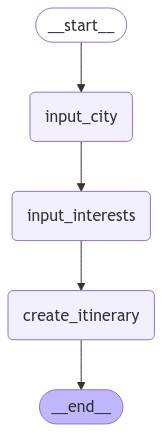

In [16]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Define the main function that runs the graph


In [17]:
def run_travel_planner(user_request: str):
    print(f"Initial Request: {user_request}\n")
    state = {
        "messages": [HumanMessage(content=user_request)],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    for output in app.stream(state):
        pass  # The nodes themselves now handle all printing

### Run Workflow Example

In [18]:
user_request = "I want to plan a day trip."
run_travel_planner(user_request)

Initial Request: I want to plan a day trip.

Please enter the city you want to visit for your day trip:
Your input: Noida, India
Please enter your interests for the trip to Noida, India (comma-separated):
Your input: Ancient architecture, food , culture
Creating an itinerary for Noida, India based on interests: Ancient architecture, food, culture...

Final Itinerary:
Certainly! Here's a day trip itinerary in Noida, India, tailored to your interests in ancient architecture, food, and culture:

**Morning:**

- **Start at the Akshardham Temple** (although it's in Delhi, it's very close to Noida and a must-visit for ancient architecture enthusiasts)
  - Opening hours: 9:30 AM (Closed on Mondays)
  - Explore the grand temple complex and its ancient-styled architecture
  - Enjoy the intricate carvings and serene gardens

- **Breakfast at a local eatery**
  - Try traditional North Indian breakfast items like Aloo Paratha, Puri Bhaji, or Chole Bhature

**Mid-Morning:**

- **Visit the ISKCON No

In [19]:
user_request = "I want to plan a day trip."
run_travel_planner(user_request)

Initial Request: I want to plan a day trip.

Please enter the city you want to visit for your day trip:
Your input: Jaipur, India
Please enter your interests for the trip to Jaipur, India (comma-separated):
Your input: Tranditional, food
Creating an itinerary for Jaipur, India based on interests: Tranditional, food...

Final Itinerary:
Certainly! Here's a day trip itinerary in Jaipur, India, focusing on traditional experiences and local food:

**Morning:**

- **8:00 AM:** Start your day with a traditional Rajasthani breakfast at Rawat Mishtan Bhandar. Try the famous pyaaz kachori with a cup of masala chai.
- **9:00 AM:** Visit the Amber Fort (Amer Fort), a beautiful example of Rajput architecture. Enjoy an elephant ride up to the fort if you're interested in a traditional mode of transport.
- **11:00 AM:** Head to the Anokhi Museum of Hand Printing to learn about the traditional craft of hand-block printing and maybe try your hand at it.

**Afternoon:**

- **1:00 PM:** Have lunch at La